In [1]:
!pip install geopandas

   dt_id dt_name                                           geometry
0      A     晨曦区  POLYGON ((121.47039 31.19127, 121.47034 31.191...
1      B     蓝湾区  POLYGON ((121.45769 31.22019, 121.45782 31.22,...
2      C     翠竹区  POLYGON ((121.42525 31.27067, 121.42521 31.270...
3      D     东城区  POLYGON ((121.41257 31.19112, 121.41208 31.191...
4      E     繁星区  POLYGON ((121.48541 31.31158, 121.4854 31.3086...
5      F     枫桥区  POLYGON ((121.35418 31.23712, 121.35581 31.237...
6      G     古藤区  POLYGON ((121.10805 31.36702, 121.1082 31.3667...
7      H     花园区  POLYGON ((121.51649 31.24695, 121.51649 31.247...
8      I     银湖区  MULTIPOLYGON (((121.31622 31.16019, 121.3153 3...
9      J     江滨区  POLYGON ((121.57047 30.99835, 121.57104 30.998...
10     K     昆仑区  MULTIPOLYGON (((121.76939 30.84587, 121.76939 ...
11     L     绿柳区  POLYGON ((121.46831 31.31604, 121.46835 31.316...
12     M     梅林区  POLYGON ((121.02804 30.94394, 121.02791 30.945...
13     N     暖风区  MULTIPOLYGON (((121.4282 30.68

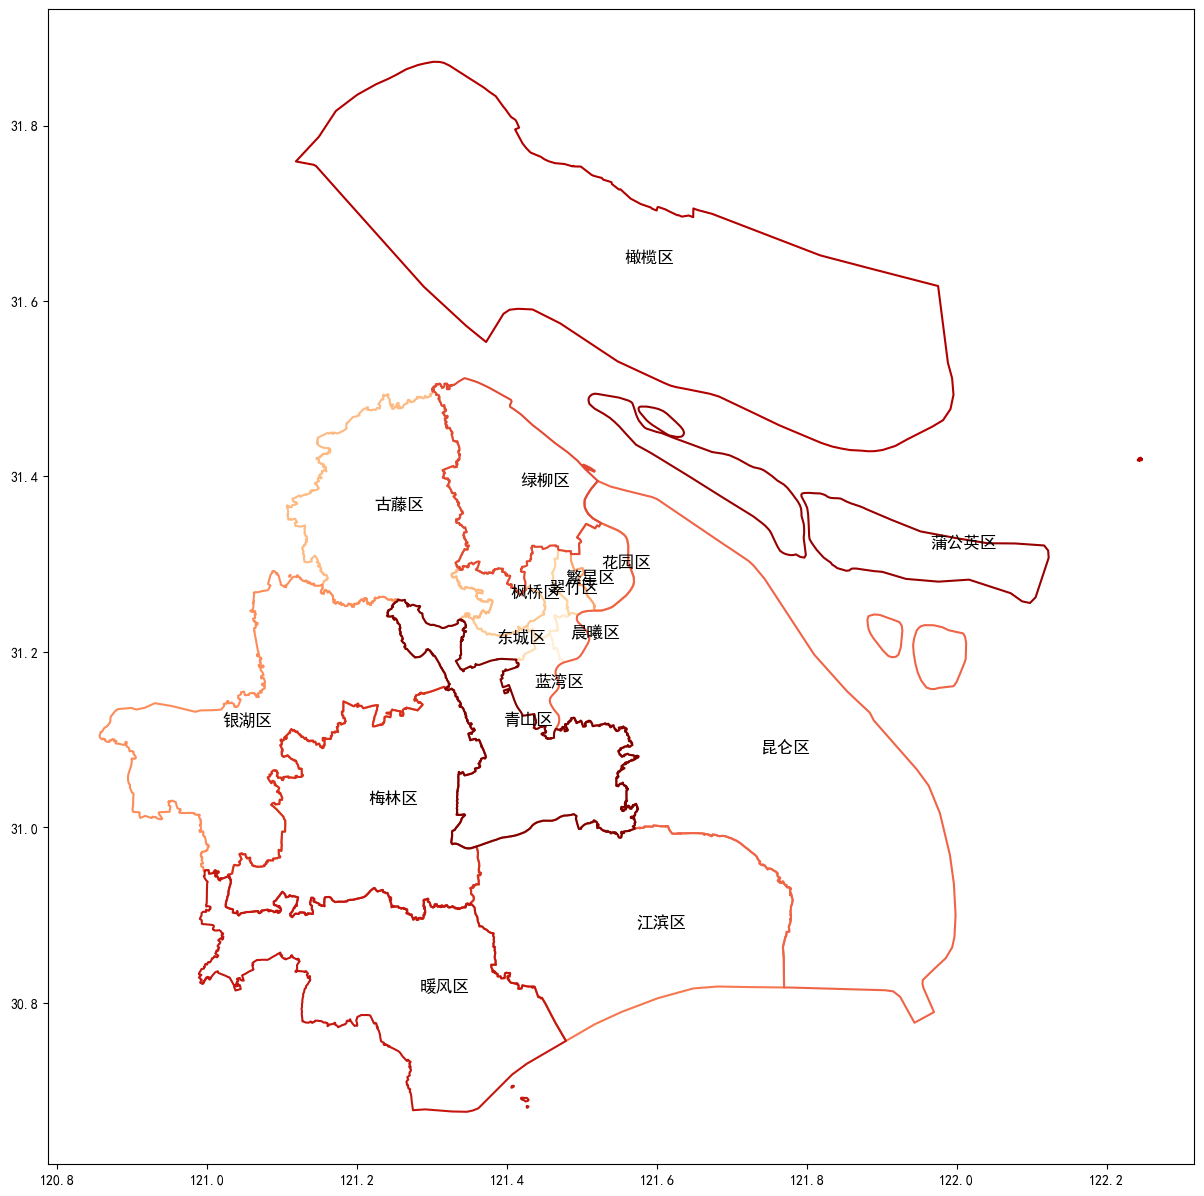

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["font.sans-serif"] = ["SimHei"]
gdf = gpd.read_file("../map/food.shp")
print(gdf)
gdf["center"] = gdf["geometry"].representative_point()
gdf_points = gdf.copy()
gdf_points.set_geometry("center", inplace = True)
gdf.boundary.plot(cmap='OrRd', figsize=(15, 15))
texts = []

for x, y, label in zip(gdf_points.geometry.x, gdf_points.geometry.y, gdf_points["dt_name"]):
    texts.append(plt.text(x, y, label, fontsize = 12))

In [3]:
# !pip install ydata-profiling
# !pip install chardet

In [4]:
import chardet
f1 = open("../dataset/food.csv","rb")
chardet.detect(f1.read())

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}

In [5]:
from ydata_profiling import ProfileReport
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False # Useless
food_df = pd.read_csv("../dataset/food.csv",encoding="utf-8")
df_report = ProfileReport(food_df)
# // df_report.to_file("../docs/report.html")

In [6]:
food_df = food_df.replace(0.0, np.nan)
food_df_clean = food_df.copy()
food_df_clean.dropna(how='any',inplace=True)
food_df_clean.drop_duplicates(keep="first",inplace=True) # ? 一大半没了
df_report = ProfileReport(food_df_clean)
# // df_report.to_file("../docs/report.html")

In [7]:
# !pip install pyecharts -U

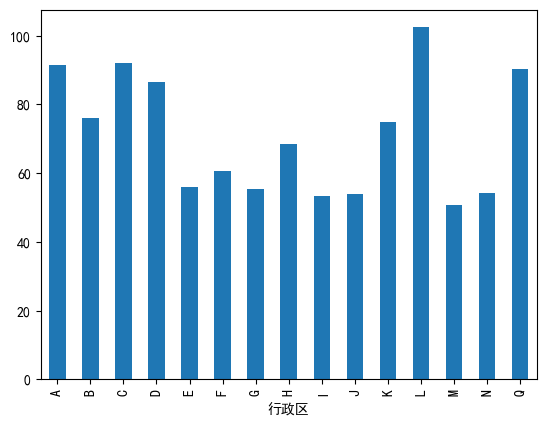

In [8]:
from pyecharts.charts import Bar
from pyecharts import options as opts
district_avg = food_df_clean['人均消费'].groupby(food_df_clean['行政区']).mean()
district_avg.plot(kind="bar")
plt.show()
# bar = (
#     Bar()
#     .add_xaxis(district_avg['行政区'].tolist())
#     .add_yaxis("人均消费",district_avg['人均消费'].tolist())
#     .set_global_opts(title_opts=opts.TitleOpts(title="行政区与人均消费间关系"))
# )
# bar.render_notebook()
# ! Key Error
# ? 没有"行政区"键值

In [9]:
# todo)) gpanda plot绘制

https://blog.csdn.net/qq_40268672/article/details/109528302

In [10]:
%pip install altair

Note: you may need to restart the kernel to use updated packages.


In [30]:
import altair as alt

click_district = alt.selection_point(fields=["行政区"])

choropleth = ( 
  alt.Chart(
    gdf.drop(columns="center").rename(columns={"dt_id": "行政区", "dt_name": "行政区名称"})
  )
  .mark_geoshape(
    stroke="white",
    strokeWidth=1
  )
  .encode(
    color=alt.Color("人均消费:Q").scale(scheme="reds").legend(orient="left"),
    tooltip=["行政区名称", "人均消费:Q"],
    opacity=alt.condition(click_district, alt.value(1), alt.value(0.2))
  )
  .transform_lookup(
    lookup="行政区",
    from_=alt.LookupData(data=food_df_clean.groupby("行政区")["人均消费"].mean().reset_index(), key="行政区", fields=["人均消费"])
  )
  .properties(
    height=600,
    width=600,
  )
  .add_params(
    click_district
  )
)

bars = (
  alt.Chart(
    food_df_clean.groupby("行政区")["人均消费"].mean().reset_index()
  )
  .mark_bar()
  .encode(
    x="人均消费",
    opacity=alt.condition(click_district, alt.value(1), alt.value(0.2)),
    color=alt.Color("人均消费:Q").scale(scheme="reds"),
    y=alt.Y("行政区").sort("-x"),
    tooltip=["人均消费:Q"]
  )
  .add_params(
    click_district
  )
  .properties(
    width=500
  )
)

text = (
  bars.mark_text(
    align="left",
    baseline="middle",
    dx=3,
    limit=50
  )
  .encode(
    text="人均消费:Q"
  )
  .add_params(
    click_district
  )
)
choropleth | (bars + text)

alt.HConcatChart(...)